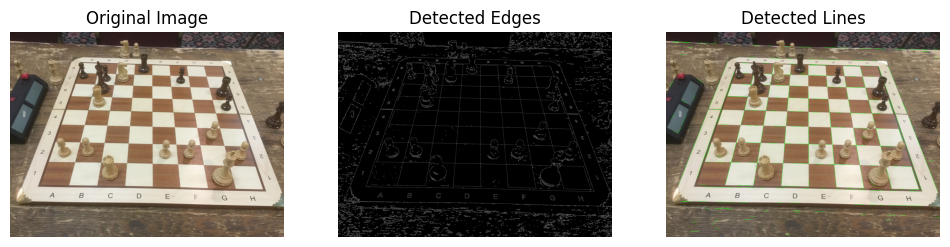

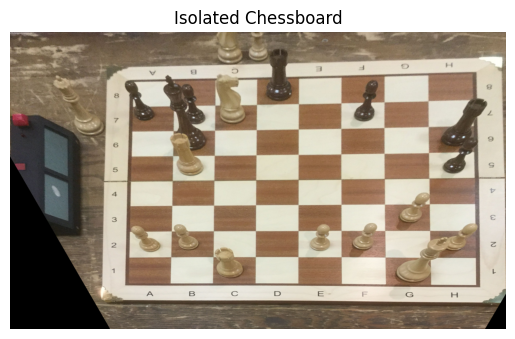

In [35]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os

def load_image(image_path):
    """Load and convert an image to grayscale."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, image_gray

def detect_edges(image_gray, threshold1=50, threshold2=150, aperture_size=3):
    """Detect edges using the Canny edge detector."""
    return cv2.Canny(image_gray, threshold1, threshold2, apertureSize=aperture_size)

def detect_lines(edges, rho=1, theta=np.pi/180, threshold=100, min_line_length=50, max_line_gap=5):
    """Detect lines using the Hough Line Transform."""
    return cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

def find_chessboard_corners(lines):
    """Find the corners of the chessboard from the detected lines."""
    if lines is None:
        raise ValueError("No lines detected, cannot find chessboard corners.")
    
    # Group lines by their orientations
    horizontal_lines = []
    vertical_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < abs(x2 - x1):  # Horizontal line
            horizontal_lines.append((x1, y1, x2, y2))
        else:  # Vertical line
            vertical_lines.append((x1, y1, x2, y2))
    
    # Sort lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda x: x[1])  # Sort by y-coordinate
    vertical_lines = sorted(vertical_lines, key=lambda x: x[0])      # Sort by x-coordinate
    
    # Use the top-most, bottom-most, left-most, and right-most lines
    if len(horizontal_lines) < 2 or len(vertical_lines) < 2:
        raise ValueError("Not enough lines to determine chessboard corners.")
    
    top_line = horizontal_lines[0]
    bottom_line = horizontal_lines[-1]
    left_line = vertical_lines[0]
    right_line = vertical_lines[-1]
    
    # Find intersections of these lines to determine the corners
    def line_intersection(line1, line2):
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denom == 0:
            raise ValueError("Lines do not intersect.")
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
        return int(px), int(py)
    
    top_left = line_intersection(top_line, left_line)
    top_right = line_intersection(top_line, right_line)
    bottom_left = line_intersection(bottom_line, left_line)
    bottom_right = line_intersection(bottom_line, right_line)
    
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")

def crop_chessboard(image, corners):
    """Crop the image to extract only the chessboard area."""
    # Order points in consistent order: top-left, top-right, bottom-right, bottom-left
    def order_points(points):
        rect = np.zeros((4, 2), dtype="float32")
        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]
        return rect

    rect = order_points(corners)

    # Determine width and height of the chessboard
    (tl, tr, br, bl) = rect
    width = max(int(np.linalg.norm(br - bl)), int(np.linalg.norm(tr - tl)))
    height = max(int(np.linalg.norm(tr - br)), int(np.linalg.norm(tl - bl)))

    # Create destination points for perspective transformation
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

    # Perform the perspective warp
    matrix = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, matrix, (width, height))

# File Path (Ensure this is correct relative to your environment)
image_path = "../data/chessboard.jpeg"

# Main Process
try:
    # Load image
    original, image_gray = load_image(image_path)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Edge Detection
    edges = detect_edges(image_gray)
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Detected Edges")
    plt.axis('off')

    # Line Detection
    lines = detect_lines(edges)
    line_image = original.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis('off')
    plt.show()

    # Find Chessboard Corners
    corners = find_chessboard_corners(lines)

    # Crop Chessboard
    cropped_chessboard = crop_chessboard(original, corners)

    # Display the cropped chessboard
    plt.imshow(cv2.cvtColor(cropped_chessboard, cv2.COLOR_BGR2RGB))
    plt.title("Isolated Chessboard")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error: {e}")
